# HVG:seurat_v3 & harmony workflow
**Author:** [Severin Dicks](https://github.com/Intron7)

To run this notebook please make sure you have a working rapids environment with all nessaray dependencies. Run the [data_downloader](https://github.com/scverse/rapids_singlecell-notebooks/blob/abc4fc6f3fe7f85cbffb94e76d190cad0ae00a5f/data_downloader.ipynb) notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of ca. 90000 cells from [Quin et al., Cell Research 2020](https://www.nature.com/articles/s41422-020-0355-0).

In [1]:
import scanpy as sc
import cupy as cp

import time
import rapids_singlecell as rsc

import warnings

warnings.filterwarnings("ignore")

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=True,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [3]:
data_load_start = time.time()

In [4]:
%%time
adata = sc.read("h5/adata.raw.h5ad")

CPU times: user 3.4 s, sys: 380 ms, total: 3.78 s
Wall time: 3.77 s


In [5]:
%%time
rsc.get.anndata_to_GPU(adata)

CPU times: user 70.7 ms, sys: 406 ms, total: 477 ms
Wall time: 477 ms


In [6]:
adata.shape

(93575, 33694)

Verify the shape of the resulting sparse matrix:

In [7]:
adata.shape

(93575, 33694)

In [8]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time - data_load_start))

Total data load and format time: 10.18742036819458


## Preprocessing

In [9]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [10]:
%%time
rsc.pp.flag_gene_family(adata, gene_family_name="MT", gene_family_prefix="MT-")

CPU times: user 6.16 ms, sys: 50 μs, total: 6.21 ms
Wall time: 6.08 ms


In [11]:
%%time
rsc.pp.flag_gene_family(adata, gene_family_name="RIBO", gene_family_prefix="RPS")

CPU times: user 5.22 ms, sys: 71 μs, total: 5.3 ms
Wall time: 5.12 ms


In [12]:
%%time
rsc.pp.calculate_qc_metrics(adata, qc_vars=["MT", "RIBO"])

CPU times: user 49 ms, sys: 3.97 ms, total: 52.9 ms
Wall time: 52.5 ms


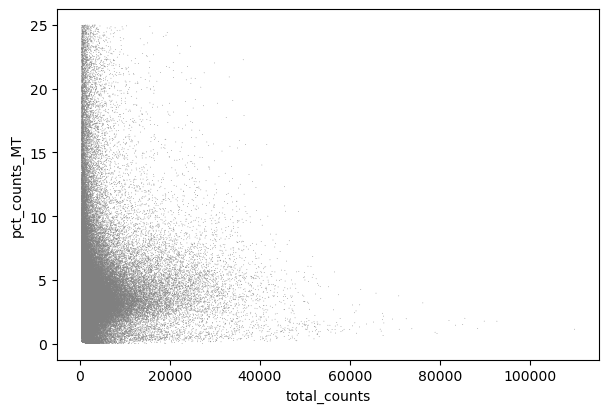

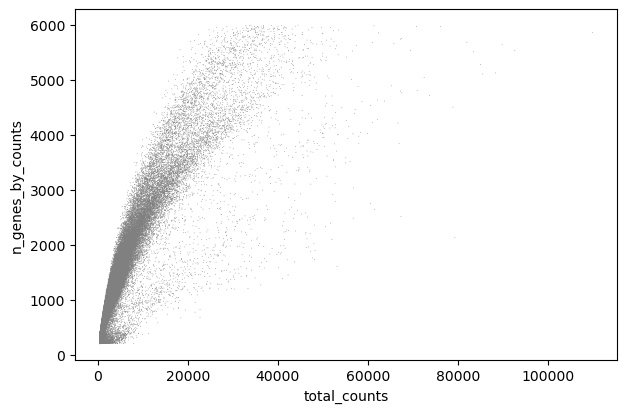

In [13]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_MT")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

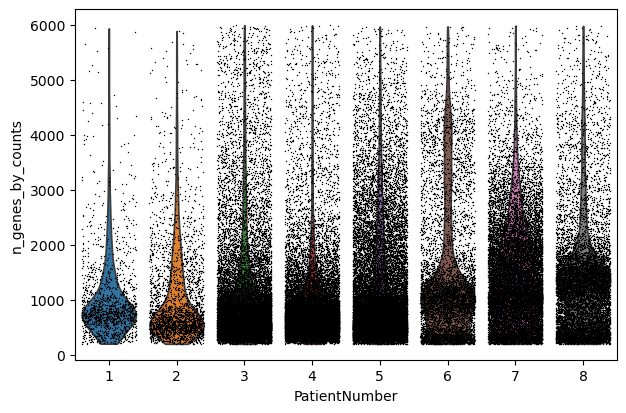

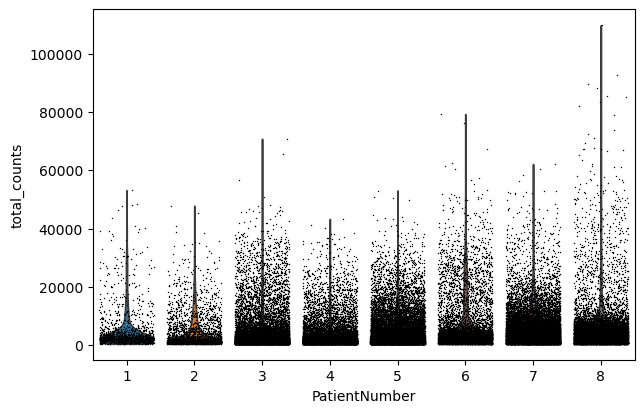

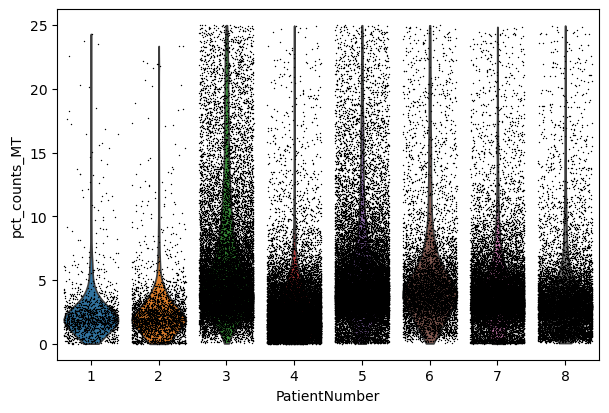

In [14]:
sc.pl.violin(adata, "n_genes_by_counts", jitter=0.4, groupby="PatientNumber")
sc.pl.violin(adata, "total_counts", jitter=0.4, groupby="PatientNumber")
sc.pl.violin(adata, "pct_counts_MT", jitter=0.4, groupby="PatientNumber")

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

In [15]:
%%time
adata = adata[adata.obs["n_genes_by_counts"] > 200]
adata = adata[adata.obs["n_genes_by_counts"] < 5000]
adata.shape

CPU times: user 31.6 ms, sys: 2.87 ms, total: 34.5 ms
Wall time: 34.2 ms


(92666, 33694)

In [16]:
%%time
adata = adata[adata.obs["pct_counts_MT"] < 20]
adata.shape

CPU times: user 11.9 ms, sys: 3.95 ms, total: 15.8 ms
Wall time: 15.4 ms


(91180, 33694)

We also filter out genes that are expressed in less than 3 cells.

In [17]:
%%time
rsc.pp.filter_genes(adata, min_count=3)

filtered out 8034 genes based on n_cells_by_counts
CPU times: user 116 ms, sys: 28 ms, total: 144 ms
Wall time: 144 ms


We store the raw expression counts in the `.layer["counts"]`

In [18]:
adata.layers["counts"] = adata.X.copy()

In [19]:
adata.shape

(91180, 25660)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [20]:
%%time
rsc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 908 μs, sys: 0 ns, total: 908 μs
Wall time: 794 μs


Next, we log transform the count matrix.

In [21]:
%%time
rsc.pp.log1p(adata)

CPU times: user 454 μs, sys: 188 μs, total: 642 μs
Wall time: 506 μs


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat` `seurat_v3` and `pearson_residuals`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects.

In this example we use `seurat_v3` for selecting highly variable genes based on the raw counts in `.layer["counts"]`

In [22]:
%%time
rsc.pp.highly_variable_genes(
    adata,
    n_top_genes=5000,
    flavor="seurat_v3",
    batch_key="PatientNumber",
    layer="counts",
)

CPU times: user 326 ms, sys: 18.7 ms, total: 344 ms
Wall time: 346 ms


Now we safe this version of the AnnData as adata.raw.

In [23]:
%%time
adata.raw = adata

CPU times: user 127 ms, sys: 135 ms, total: 262 ms
Wall time: 261 ms


Now we restrict our AnnData object to the highly variable genes.

In [24]:
%%time
adata = adata[:, adata.var["highly_variable"]]

CPU times: user 120 ms, sys: 143 ms, total: 264 ms
Wall time: 262 ms


In [25]:
adata.shape

(91180, 5000)

Next we regress out effects of counts per cell and the mitochondrial content of the cells. As you can with scanpy you can use every numerical column in `.obs` for this.

In [26]:
%%time
rsc.pp.regress_out(adata, keys=["total_counts", "pct_counts_MT"])

CPU times: user 2.06 s, sys: 306 ms, total: 2.37 s
Wall time: 2.37 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations.

In [27]:
%%time
rsc.pp.scale(adata, max_value=10)

CPU times: user 183 ms, sys: 3.96 ms, total: 187 ms
Wall time: 186 ms


### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from cuMLs.

In [28]:
%%time
rsc.pp.pca(adata, n_comps=100)

CPU times: user 1.23 s, sys: 146 ms, total: 1.38 s
Wall time: 1.38 s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

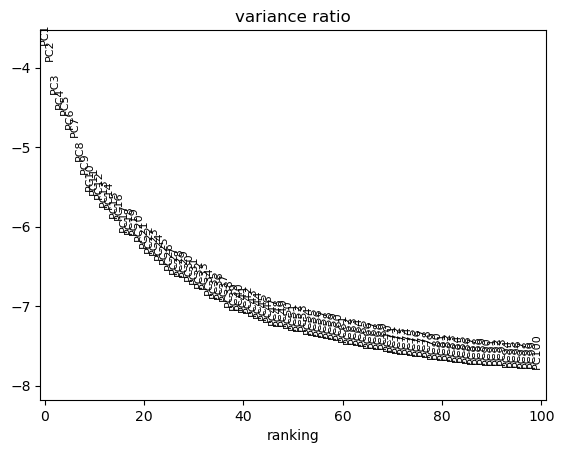

In [29]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=100)

Now we move `.X` and `.layers` out of the GPU.

In [30]:
%%time
rsc.get.anndata_to_CPU(adata, convert_all=True)

CPU times: user 277 ms, sys: 335 ms, total: 612 ms
Wall time: 611 ms


In [31]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time - preprocess_start))

Total Preprocessing time: 48.98772859573364


We have now finished the preprocessing of the data.

## Batch Correction

In [32]:
%%time
rsc.pp.harmony_integrate(adata, key="PatientNumber", dtype = cp.float32)

CPU times: user 3.82 s, sys: 81.4 ms, total: 3.9 s
Wall time: 3.91 s


## Clustering and Visualization

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using rsc.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the exact graph. Both methods are valid, but you might see differences.

In [33]:
%%time
rsc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)

CPU times: user 326 ms, sys: 198 ms, total: 524 ms
Wall time: 660 ms


Next we calculate the UMAP embedding using rapdis.

In [34]:
%%time
rsc.tl.umap(adata)

CPU times: user 203 ms, sys: 23.9 ms, total: 227 ms
Wall time: 226 ms


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering.

In [35]:
%%time
rsc.tl.louvain(adata, resolution=0.6)

CPU times: user 873 ms, sys: 116 ms, total: 989 ms
Wall time: 989 ms


In [36]:
%%time
rsc.tl.leiden(adata, resolution=0.6)

CPU times: user 561 ms, sys: 44.2 ms, total: 605 ms
Wall time: 605 ms


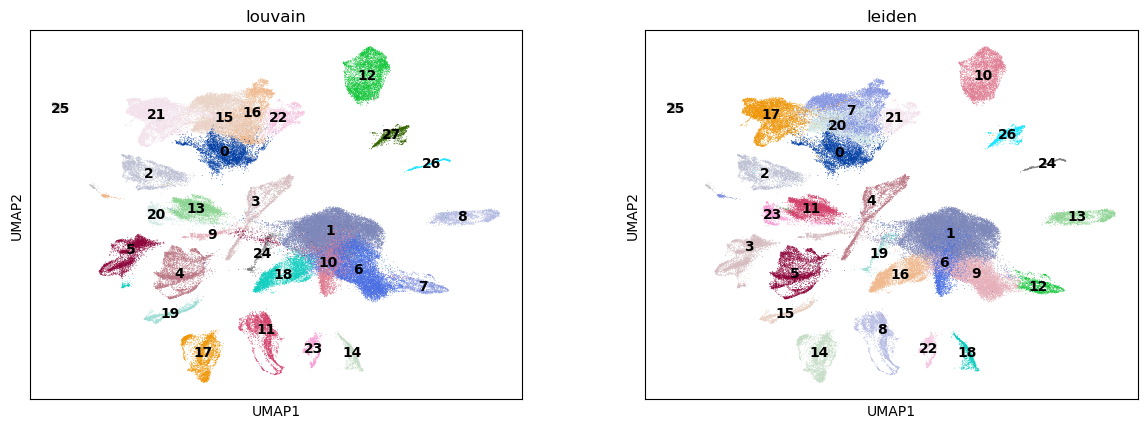

CPU times: user 716 ms, sys: 179 ms, total: 894 ms
Wall time: 687 ms


In [37]:
%%time
sc.pl.umap(adata, color=["louvain", "leiden"], legend_loc="on data")

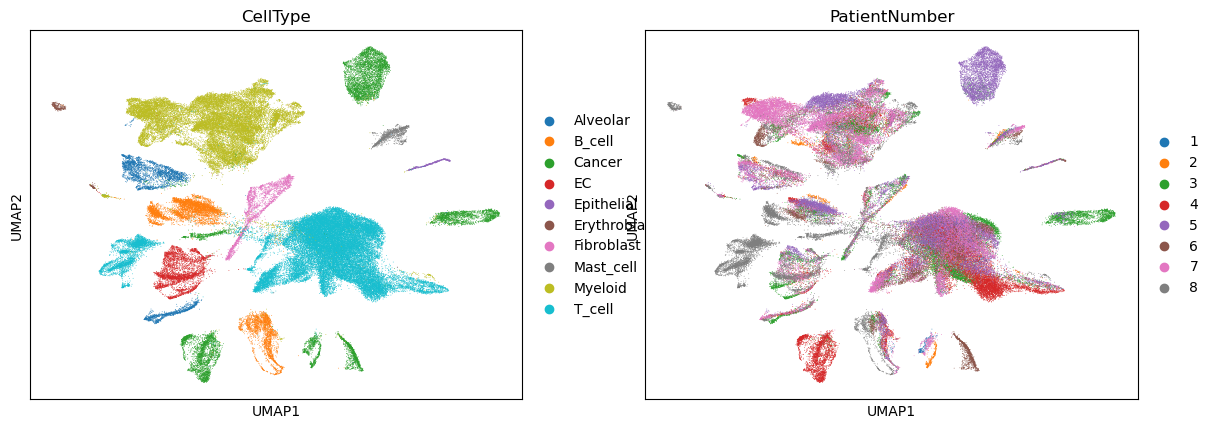

In [38]:
sc.pl.umap(adata, color=["CellType", "PatientNumber"])

We also calculate the embedding density in the UMAP using cuML

In [39]:
%%time
rsc.tl.embedding_density(adata, groupby="PatientNumber")

CPU times: user 2.27 s, sys: 65.1 ms, total: 2.33 s
Wall time: 2.33 s


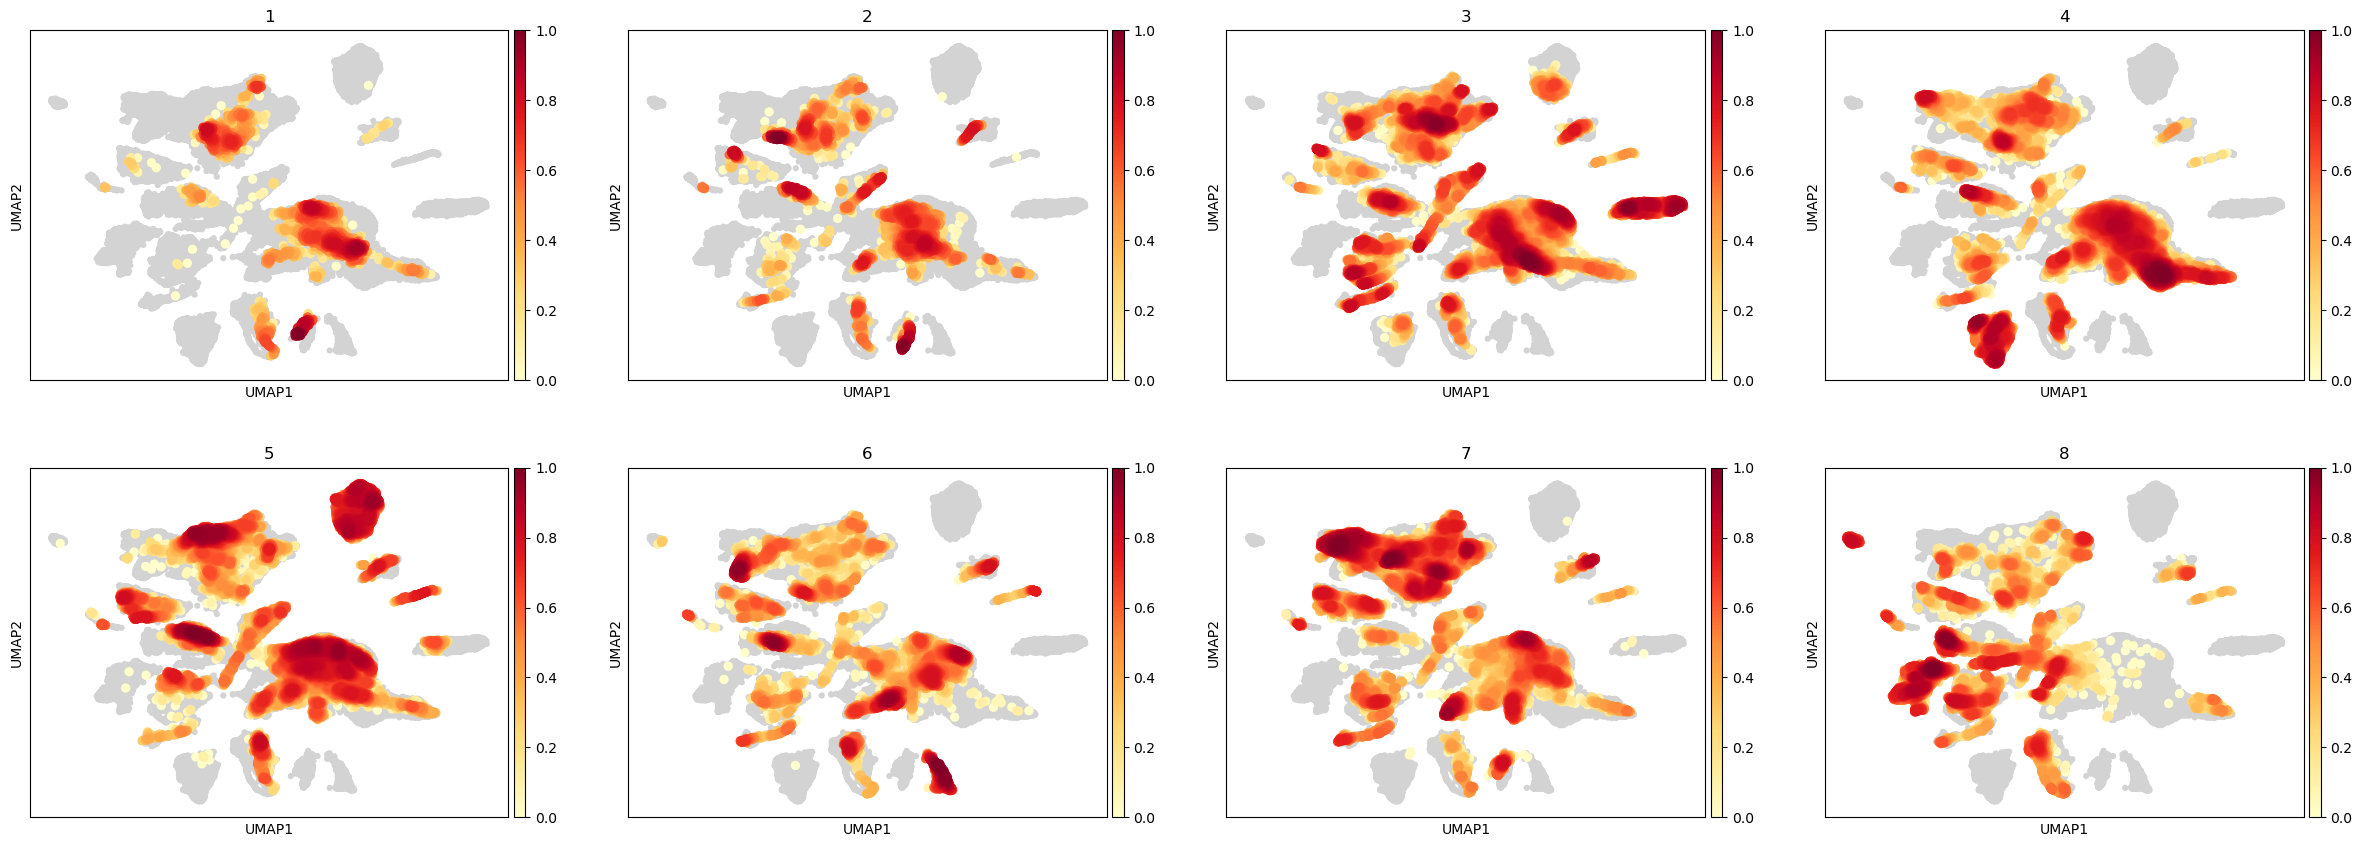

In [40]:
sc.pl.embedding_density(adata, groupby="PatientNumber")

### TSNE + k-Means

Next we use TSNE on the GPU to visualize the cells in two dimensions. We also perform k-Means clustering of the cells into 8 clusters.

In [41]:
%%time
rsc.tl.tsne(adata, n_pcs=40)

[W] [22:57:05.112227] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 1.26 s, sys: 1.1 s, total: 2.36 s
Wall time: 2.35 s


In [42]:
rsc.tl.kmeans(adata, n_clusters=8)

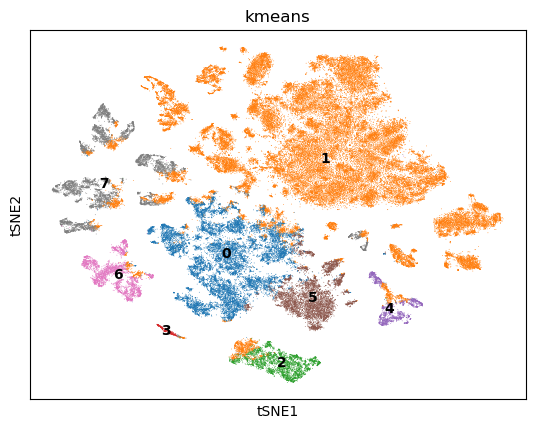

CPU times: user 380 ms, sys: 174 ms, total: 555 ms
Wall time: 347 ms


In [43]:
%%time
sc.pl.tsne(adata, color=["kmeans"], legend_loc="on data")

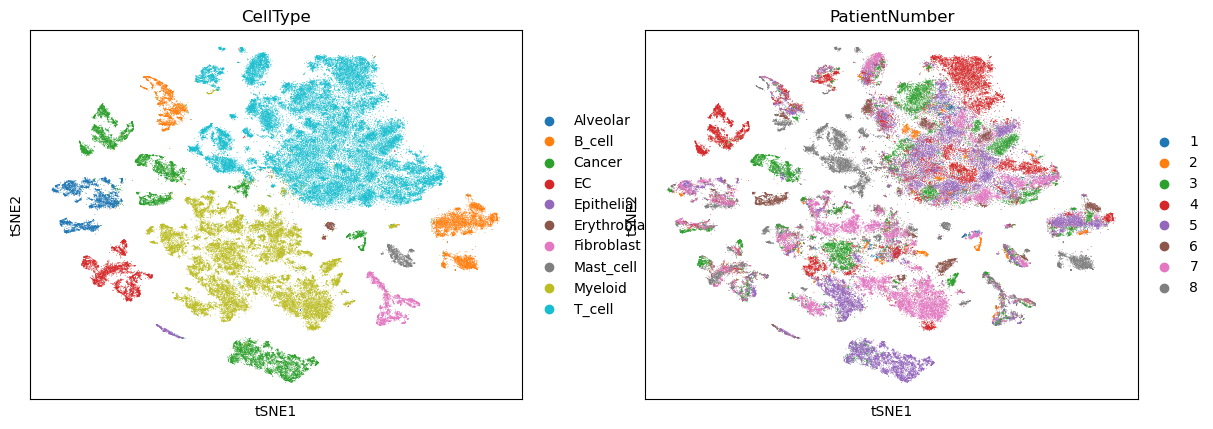

In [44]:
sc.pl.tsne(adata, color=["CellType", "PatientNumber"])

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvain cluster.

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [45]:
%%time
rsc.tl.rank_genes_groups_logreg(adata, groupby="CellType", use_raw=False)

CPU times: user 3.25 s, sys: 1.73 s, total: 4.98 s
Wall time: 4.98 s


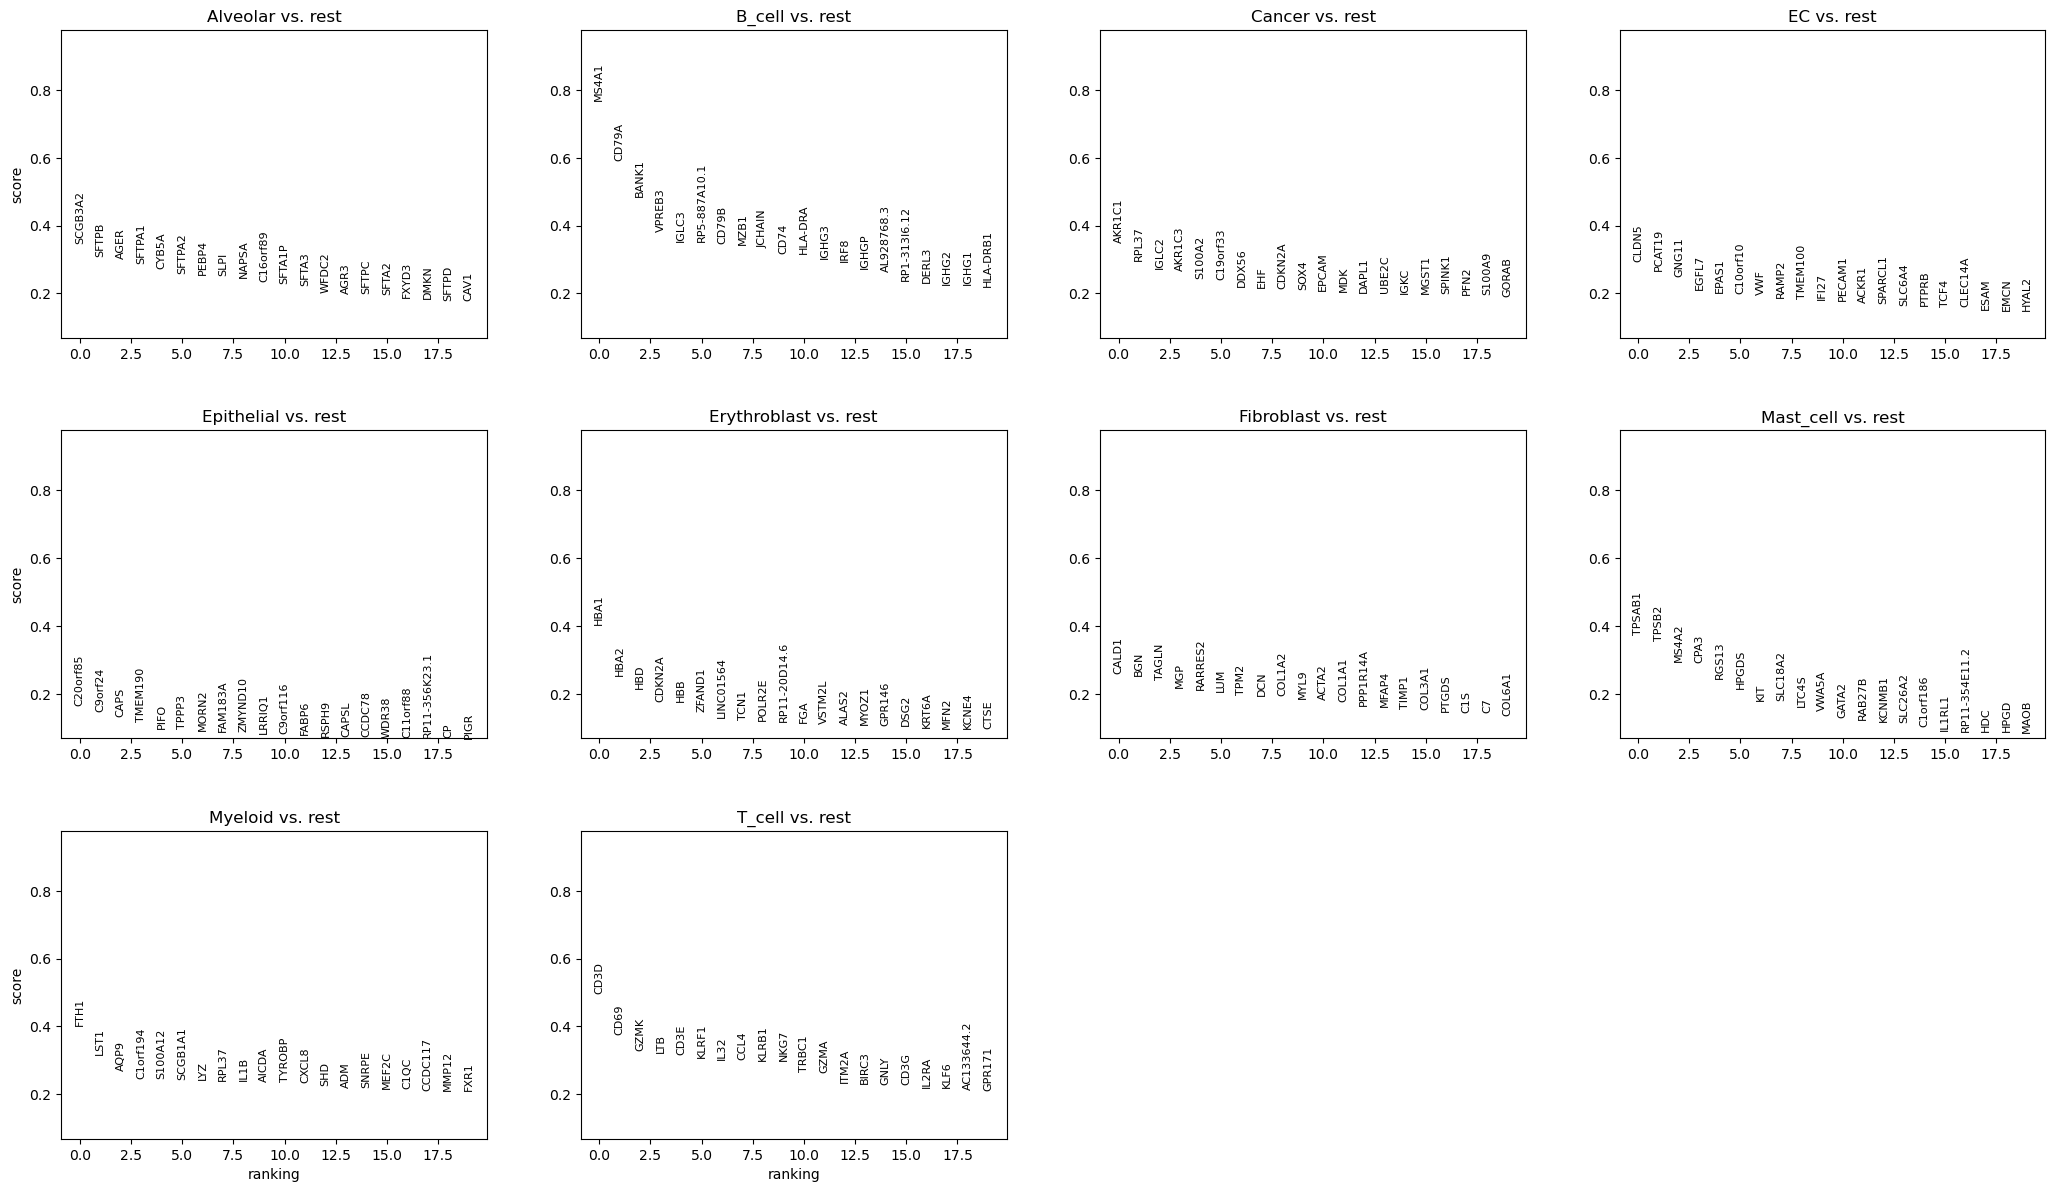

CPU times: user 829 ms, sys: 208 ms, total: 1.04 s
Wall time: 827 ms


In [46]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [47]:
post_time = time.time()

In [48]:
print("Total Postprocessing time: %s" % (post_time - preprocess_time))

Total Postprocessing time: 48.144914388656616


## Diffusion Maps

With cupy 9 its possible to compute Eigenvalues of sparse matrixes. We now create a Diffusion Map of the T-Cells to look at trajectories.

First we create a subset of only the T-Cells

In [49]:
tdata = adata[adata.obs["CellType"] == "T_cell", :].copy()

We can repeat the dimension reduction, clustering and visulatization.

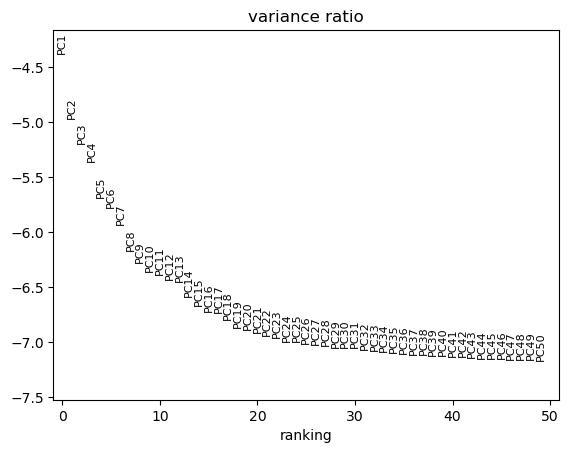

CPU times: user 1.34 s, sys: 766 ms, total: 2.1 s
Wall time: 1.91 s


In [50]:
%%time
rsc.tl.pca(tdata, n_comps=50)
sc.pl.pca_variance_ratio(tdata, log=True, n_pcs=50)

In [51]:
%%time
rsc.pp.neighbors(tdata, n_neighbors=15, n_pcs=20)
rsc.tl.umap(tdata)
rsc.tl.louvain(tdata)

CPU times: user 394 ms, sys: 27.1 ms, total: 421 ms
Wall time: 421 ms


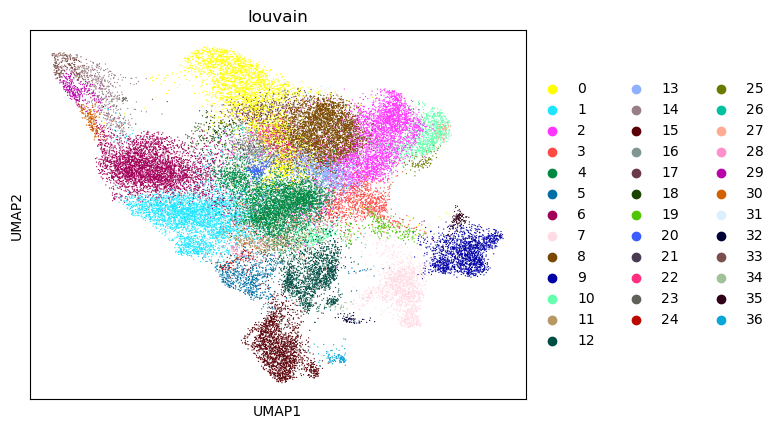

In [52]:
sc.pl.umap(tdata, color=["louvain"])

As stated before Diffusion Maps have become an integral part of single cell analysis.

In [53]:
%%time
rsc.tl.diffmap(tdata)

CPU times: user 176 ms, sys: 5.9 ms, total: 182 ms
Wall time: 181 ms


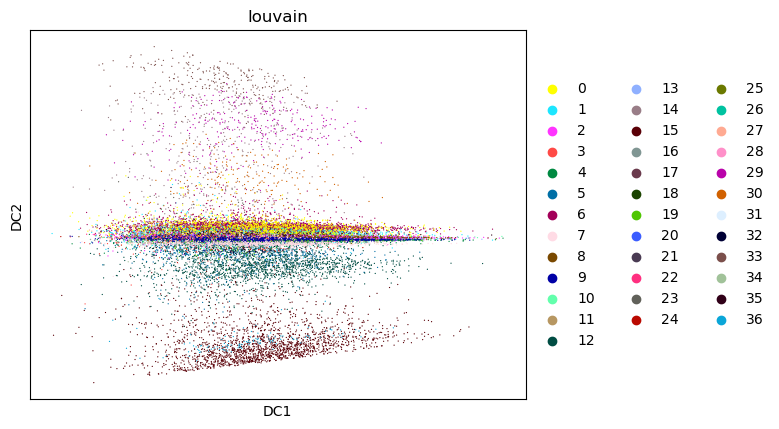

In [54]:
sc.pl.diffmap(tdata, color="louvain")

In [55]:
%%time
rsc.tl.draw_graph(tdata)

CPU times: user 311 ms, sys: 27.1 ms, total: 338 ms
Wall time: 338 ms


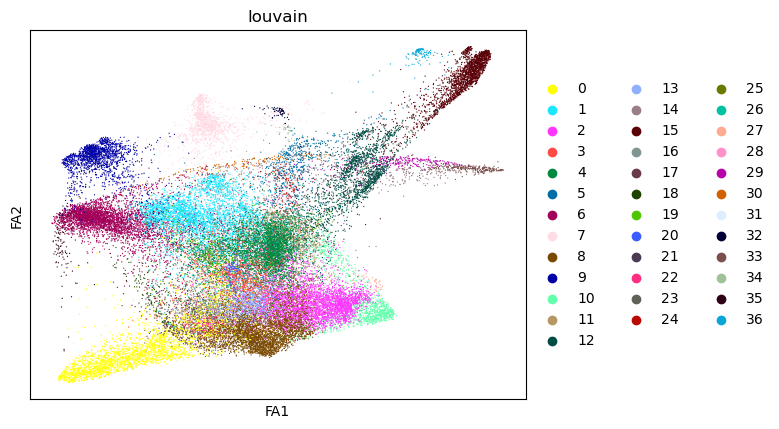

In [56]:
sc.pl.draw_graph(tdata, color="louvain")

After this you can use `X_diffmap` for `sc.pp.neighbors` and other functions. 

In [57]:
print("Total Processing time: %s" % (time.time() - preprocess_start))

Total Processing time: 131.36744451522827
